In [1]:
## Train a model to classify the images
#
## Import libraries

import os
import numpy as np

from tensorflow import keras
np.random.seed(0)

import src.config as config
from src.dataloader import read_train, read_val
from src.preprocessing import CustomDataGenerator
from src.results import plot_history, plot_cm, class_report,\
                            save_params, write_summary
from src.utils import setup_logger, header
import argparse
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


RAW_DATA_PATH = 'input/data/raw'
META_PATH = 'input/metadata/'

## Set up constants
LEARNING_RATE = .00001
BATCH_SIZE = 64
EPOCHS = 15
EXPNAME = "experiment"
EVENTNAME = f"lr_{LEARNING_RATE}_bs_{BATCH_SIZE}_ep_{EPOCHS}"
OUTPUT_FOLDER = "notebooks/experiments/augmentation_3conv_3dense/output"


#Readind data directly from the csv file and raw images in order to use data augmentation
df_labels = pd.read_csv(os.path.join(META_PATH, 'MAMe_labels.csv'), header=None, names=['id', 'label'])
df_labels['label'] = df_labels['label'].str.strip()
df_info = pd.read_csv(META_PATH + 'MAMe_dataset.csv')
df_info["Medium"] = df_info["Medium"].str.strip()
df_load_data = df_info.merge(df_labels, right_on='label', left_on='Medium')[['Image file', 'Subset', 'Medium']]

df_load_data

2023-11-28 23:00:35.243860: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 23:00:35.264933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 23:00:35.584258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,Image file,Subset,Medium
0,436018.jpg,train,Oil on canvas
1,11779.jpg,train,Oil on canvas
2,19022.jpg,train,Oil on canvas
3,435883.jpg,train,Oil on canvas
4,10481.jpg,train,Oil on canvas
...,...,...,...
37402,261318.jpg,test,Albumen photograph
37403,646703.jpg,test,Albumen photograph
37404,417445.jpg,test,Albumen photograph
37405,646328.jpg,test,Albumen photograph


In [3]:

datagen = ImageDataGenerator(
                                # rotation_range=30,        # Random rotation between -30 and 30 degrees
                                # width_shift_range=0.125,    # Random horizontal shifting (crop)
                                # height_shift_range=0.125,   # Random vertical shifting (crop)
                                # horizontal_flip=True,     # Randomly flip images horizontally
                                # rescale=1./255.,          # Rescale pixel values to the range [0, 1]
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation

)

val_datagen = ImageDataGenerator(rescale=1./255.,
                                # preprocessing_function=lambda x: center_crop(x, 200, 200),
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation
)
# val_datagen.mean = 0.5
# val_datagen.std = 0.5

# val_datagen.mean = 0.5795
# val_datagen.std = 4.22
# df_load_data['id'] = df_load_data['id'].astype('str') # requires target in string format

train_generator_df = datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'train'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)

val_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)


test_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'],
                                                    directory=RAW_DATA_PATH,
                                                    x_col="Image file", 
                                                    y_col="Medium",
                                                    class_mode="sparse",
                                                    target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=2020)

y_val = val_generator_df.classes
labels = list(train_generator_df.class_indices.keys())

# model = keras.models.load_model('interesting/lr_2e-06_bs_128_ep_200/model.h5')

# model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

Found 20300 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.


In [6]:
model.evaluate(test_generator_df)

23/23 [==============================] - 2s 73ms/step - loss: 1.6016 - accuracy: 0.5179


[1.6015530824661255, 0.5179310441017151]

23/23 [==============================] - 1s 56ms/step


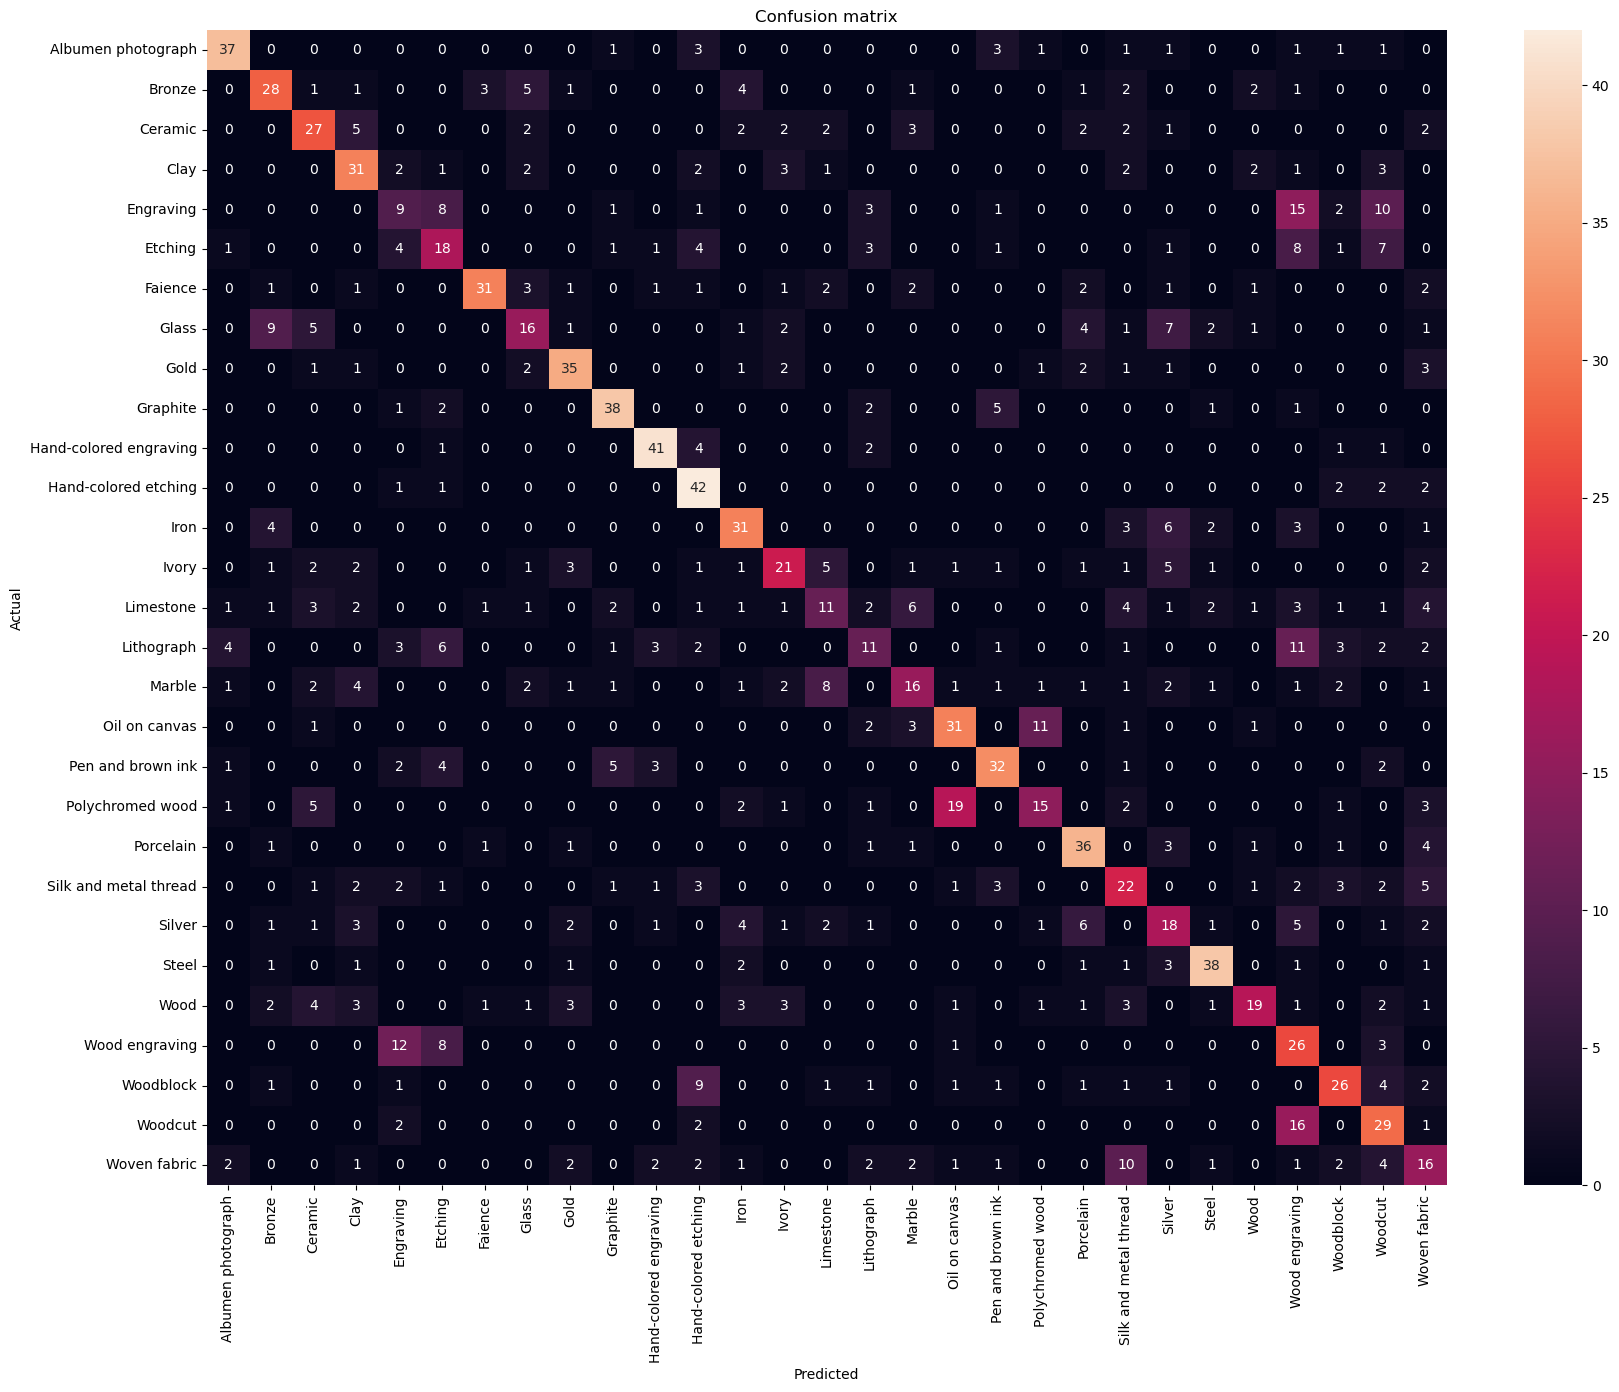

In [7]:
from src.results import plot_history, plot_cm, class_report

y_pred = model.predict(test_generator_df)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator_df.labels

plot_cm(y_true, y_pred, df_labels.label.unique());

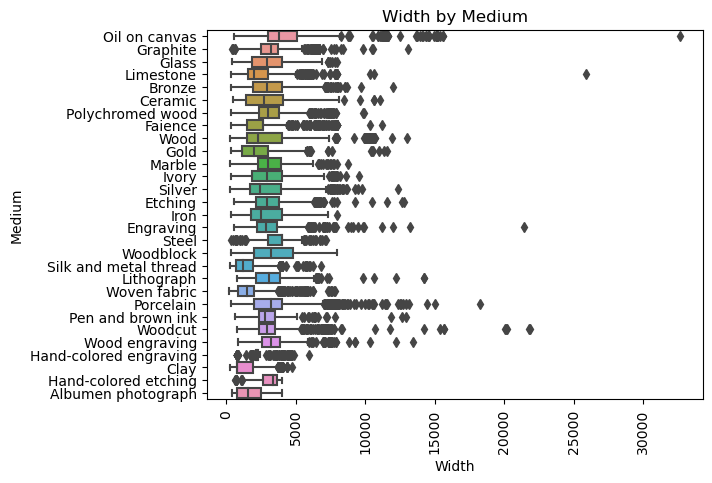

In [23]:
import seaborn as sns

# boxplot of widts by Medium
sns.boxplot(y='Medium', x='Width', data=df_info, orient='h')
plt.title('Width by Medium')
plt.xticks(rotation=90)
plt.show()

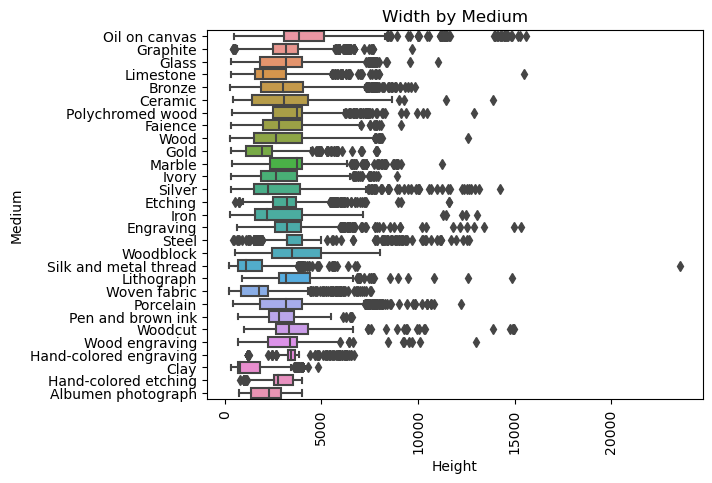

In [24]:
sns.boxplot(y='Medium', x='Height', data=df_info, orient='h')
plt.title('Width by Medium')
plt.xticks(rotation=90)
plt.show()

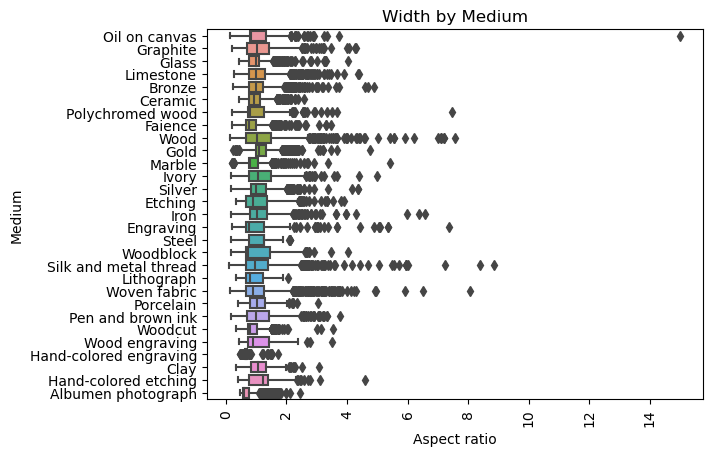

In [25]:
sns.boxplot(y='Medium', x='Aspect ratio', data=df_info, orient='h')
plt.title('Width by Medium')
plt.xticks(rotation=90)
plt.show()

In [26]:
df_info.columns

Index(['Image file', 'Medium', 'Museum', 'Museum-based instance ID', 'Subset',
       'Width', 'Height', 'Product size', 'Aspect ratio'],
      dtype='object')

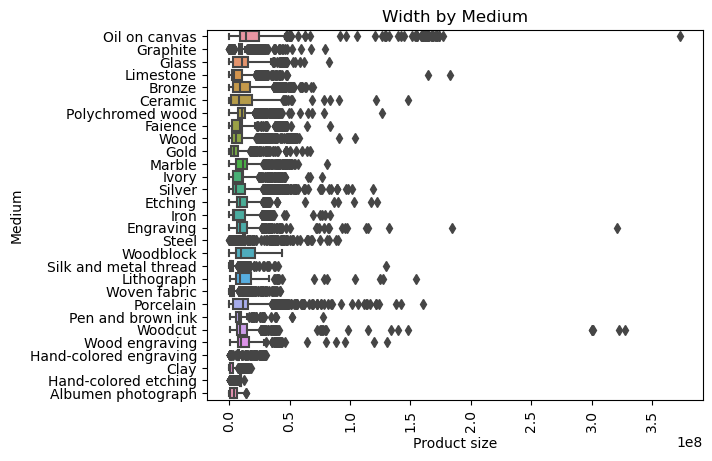

In [34]:
sns.boxplot(y='Medium', x='Product size', data=df_info, orient='h')
plt.title('Width by Medium')
plt.xticks(rotation=90)
plt.show()

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


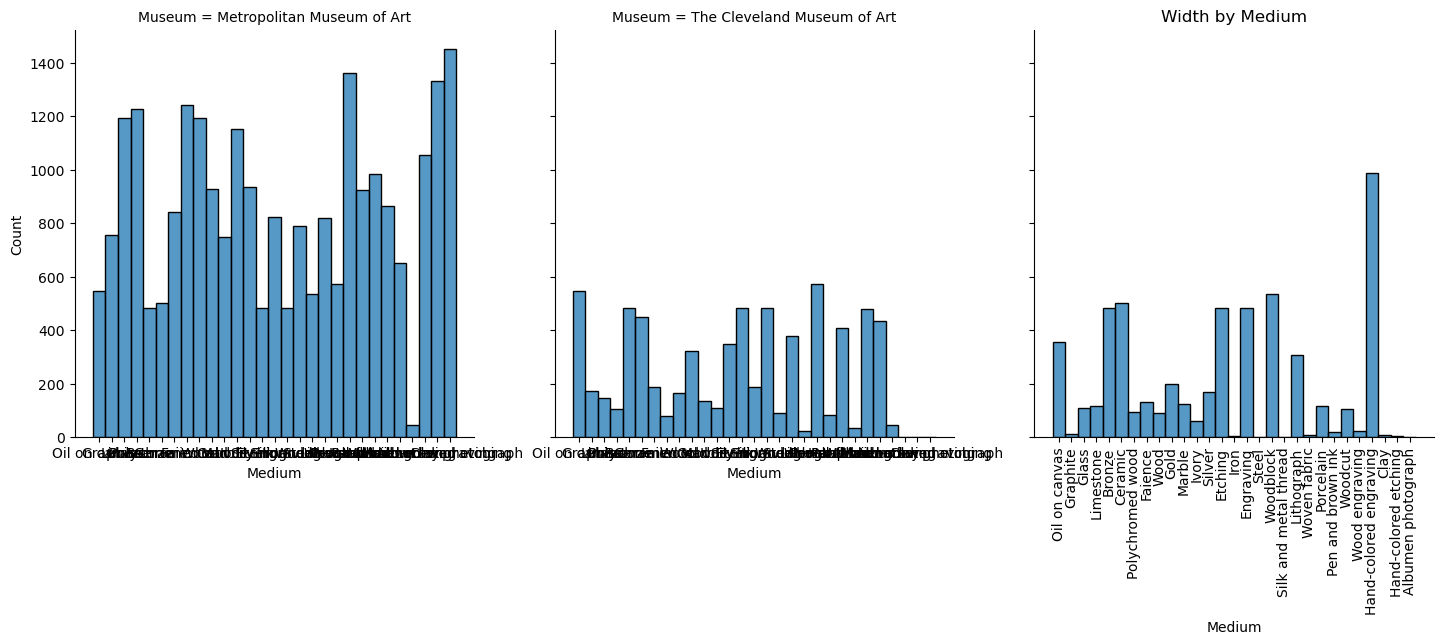

In [32]:
sns.displot(x='Medium', col="Museum", data=df_info)
plt.title('Width by Medium')
plt.xticks(rotation=90)
plt.show()

In [36]:
[layer.name for layer in model.layers]

['conv2d',
 'batch_normalization',
 'max_pooling2d',
 'conv2d_1',
 'batch_normalization_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1',
 'dense_2']

In [43]:
# Extract feature extractors
layer_conv = model.layers[:-4]
conv_layers = [layer.name for layer in layer_conv]
[layer.name for layer in model.layers]

['conv2d',
 'batch_normalization',
 'max_pooling2d',
 'conv2d_1',
 'batch_normalization_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1',
 'dense_2']

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                        

In [122]:
grad_model = keras.models.Model(
        model.inputs, 
        [model.get_layer('dense_1').output, model.output]
    )

features = grad_model.predict(test_generator_df)

23/23 [==============================] - 1s 62ms/step


In [124]:
def combine_features(model, metadata, dataflow):
    
    grad_model = keras.models.Model(
        model.inputs, 
        model.get_layer('dense_1').output
    )
    features = grad_model.predict(dataflow)
    df_features = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(features.shape[1])])
    df_features['id'] = dataflow.filenames
    df_data = metadata.merge(df_features, left_on='Image file', right_on='id')
    df_data.drop(columns=['Image file', 'Medium', 'Museum-based instance ID',	'Subset', 'id'], inplace=True)
    return df_data

X_train = combine_features(model, df_info, train_generator_df)
X_train

318/318 [==============================] - 110s 344ms/step


,Museum,Width,Height,Product size,Aspect ratio,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,Metropolitan Museum of Art,3144.0,3840.0,12072960.0,0.8187,4.735958,2.593842,1.377160,11.896188,14.523554,...,0.0,8.904529,0.802160,0.000000,0.000000,5.789402,0.000000,0.000000,0.0,6.832998
1,Metropolitan Museum of Art,1707.0,2136.0,3646152.0,0.7992,1.514788,0.000000,0.000000,13.058764,7.977312,...,0.0,8.355429,2.059060,0.000000,0.000000,4.073452,0.000000,0.000000,0.0,10.393115
2,Metropolitan Museum of Art,2845.0,3811.0,10842295.0,0.7465,0.557901,3.415720,0.899145,3.591190,0.183158,...,0.0,5.205397,6.347085,0.000000,0.000000,1.848637,0.338900,0.678688,0.0,0.746021
3,Metropolitan Museum of Art,3811.0,2916.0,11112876.0,1.3069,4.412485,4.521524,6.274419,3.229139,0.000000,...,0.0,3.983204,16.923376,0.642790,1.827336,5.066409,0.948332,0.000000,0.0,0.506053
4,Metropolitan Museum of Art,3811.0,2099.0,7999289.0,1.8156,0.000000,4.853436,2.673041,12.044879,8.991763,...,0.0,10.698861,6.693420,0.000000,1.258265,5.434381,0.143723,0.000000,0.0,5.342811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20295,Metropolitan Museum of Art,808.0,1413.0,1141704.0,0.5718,10.023689,0.000000,0.000000,8.031855,12.249212,...,0.0,8.902767,0.000000,6.129060,1.253689,6.840182,2.698920,0.000000,0.0,3.950421
20296,Metropolitan Museum of Art,2234.0,3413.0,7624642.0,0.6546,9.941308,0.000000,0.948599,6.351785,12.332706,...,0.0,5.564298,0.000000,5.198676,0.657803,7.252346,5.075764,0.000000,0.0,0.000000
20297,Metropolitan Museum of Art,1470.0,2789.0,4099830.0,0.5271,1.361014,2.693881,5.543188,10.540603,2.783749,...,0.0,10.548314,7.554432,0.000000,0.000000,3.728440,0.051744,0.000000,0.0,4.132973
20298,Metropolitan Museum of Art,452.0,840.0,379680.0,0.5381,8.076812,0.000000,2.143079,6.155283,7.098219,...,0.0,3.657672,0.363388,2.776424,3.835326,7.307541,3.102435,0.000000,0.0,0.000000


In [126]:
X_val = combine_features(model, df_info, val_generator_df)
X_val

23/23 [==============================] - 1s 59ms/step


,Museum,Width,Height,Product size,Aspect ratio,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,Metropolitan Museum of Art,3438.0,3842.0,13208796.0,0.8948,5.777895,0.000000,3.397733,17.942087,15.437311,...,0.0,11.275904,1.090572,0.000000,0.000000,7.673688,0.000000,0.000000,0.0,3.382261
1,Metropolitan Museum of Art,3052.0,3722.0,11359544.0,0.8200,8.968793,0.584824,2.911151,6.325661,7.670918,...,0.0,3.343849,0.000000,3.795063,2.487947,6.119161,7.105369,0.058845,0.0,0.000000
2,Metropolitan Museum of Art,3369.0,3850.0,12970650.0,0.8751,10.851788,0.200776,0.000000,10.621066,14.953054,...,0.0,8.455424,0.000000,1.121158,0.000000,7.097460,0.654329,0.000000,0.0,6.735138
3,Metropolitan Museum of Art,3811.0,1173.0,4470303.0,3.2489,6.920224,1.139140,1.964729,7.858814,7.822034,...,0.0,4.855903,0.000000,0.873405,0.566927,2.863229,3.539808,0.000000,0.0,6.497814
4,Metropolitan Museum of Art,3811.0,2702.0,10297322.0,1.4104,7.150406,1.234280,0.000000,6.764498,9.864944,...,0.0,7.710195,0.000000,4.391593,0.000000,4.935201,1.274988,0.000000,0.0,7.845001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,Metropolitan Museum of Art,2170.0,2153.0,4672010.0,1.0079,8.983281,3.117761,1.306209,13.773096,15.556276,...,0.0,8.507582,0.000000,0.000000,0.000000,6.793885,0.000000,0.000000,0.0,9.235932
1446,Metropolitan Museum of Art,4000.0,3073.0,12292000.0,1.3017,7.367799,1.135575,3.975646,8.469115,7.923261,...,0.0,3.963136,4.529950,0.590965,2.747362,11.553326,0.938616,0.000000,0.0,0.000000
1447,Metropolitan Museum of Art,799.0,1388.0,1109012.0,0.5756,3.455144,3.707082,2.801713,8.895642,8.889305,...,0.0,10.066724,8.944369,0.000000,0.000000,12.489367,0.000000,0.000000,0.0,0.011132
1448,Metropolitan Museum of Art,3294.0,2463.0,8113122.0,1.3374,6.851538,0.602137,0.313130,11.163988,10.655949,...,0.0,5.155170,0.878797,0.000000,1.687799,5.903933,0.157369,0.000000,0.0,3.317837


In [127]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_train_prep = X_train.copy()
scaler = StandardScaler()
cat_feats = ['Museum']
num_feats = [col for col in X_train_prep.columns if 'Museum' not in col]
X_train_prep[num_feats] = scaler.fit_transform(X_train_prep[num_feats])

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train_prep[cat_feats])
ohe_feats = pd.DataFrame(ohe.transform(X_train_prep[cat_feats]))
X_train_prep = pd.concat([X_train_prep[num_feats], ohe_feats], axis=1)

X_val_prep = X_val.copy()
X_val_prep[num_feats] = scaler.transform(X_val_prep[num_feats])
ohe_val_feats = ohe.transform(X_val_prep[cat_feats])
X_val_prep = pd.concat([X_val_prep[num_feats], pd.DataFrame(ohe_val_feats)], axis=1)

X_train_prep = X_train_prep.values
X_val_prep = X_val_prep.values

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [166]:
# Use xgboost classifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train_prep, label=train_generator_df.classes)
dval = xgb.DMatrix(X_val_prep, label=val_generator_df.classes)

param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softprob', 'num_class': 29}
param['nthread'] = 4
param['eval_metric'] = 'mlogloss'
param['learning_rate'] = 0.005
param['verbosity'] = 0
param['subsample'] = 0.8
param['colsample_bytree'] = 0.8
param['colsample_bylevel'] = 0.8
param['min_child_weight'] = 1
param['gamma'] = 0
param['reg_alpha'] = 0
param['reg_lambda'] = 1
param['scale_pos_weight'] = 1
param['seed'] = 0
param['n_estimators'] = 1000
param['early_stopping_rounds'] = 50

evallist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 10000
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=10)


y_pred = np.argmax(bst.predict(dval), axis=1)
accuracy_score(y_val, y_pred)

[0]	eval-mlogloss:3.36372	train-mlogloss:3.36368
[10]	eval-mlogloss:3.32458	train-mlogloss:3.32387
[20]	eval-mlogloss:3.28990	train-mlogloss:3.28841
[30]	eval-mlogloss:3.25754	train-mlogloss:3.25543
[40]	eval-mlogloss:3.22871	train-mlogloss:3.22576
[50]	eval-mlogloss:3.20302	train-mlogloss:3.19947
[60]	eval-mlogloss:3.17936	train-mlogloss:3.17490
[70]	eval-mlogloss:3.15723	train-mlogloss:3.15160
[80]	eval-mlogloss:3.13687	train-mlogloss:3.13041
[90]	eval-mlogloss:3.11716	train-mlogloss:3.10964
[100]	eval-mlogloss:3.09922	train-mlogloss:3.09079
[110]	eval-mlogloss:3.08222	train-mlogloss:3.07297
[120]	eval-mlogloss:3.06606	train-mlogloss:3.05576
[130]	eval-mlogloss:3.05070	train-mlogloss:3.03970
[140]	eval-mlogloss:3.03586	train-mlogloss:3.02389
[150]	eval-mlogloss:3.02194	train-mlogloss:3.00904
[160]	eval-mlogloss:3.00845	train-mlogloss:2.99494
[170]	eval-mlogloss:2.99525	train-mlogloss:2.98109
[180]	eval-mlogloss:2.98312	train-mlogloss:2.96819
[190]	eval-mlogloss:2.97136	train-mlogloss

KeyboardInterrupt: 

In [129]:
class_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train_prep.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(29, activation='softmax')
])

class_model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

y_train, y_val = np.array(train_generator_df.classes), np.array(val_generator_df.classes)
history_class = class_model.fit(X_train_prep, 
                                y_train.reshape(-1, 1),
                                epochs=100, 
                                validation_data=(X_val_prep, y_val),
                                batch_size=16)

Epoch 1/100
1269/1269 [==============================] - 1s 971us/step - loss: 3.4295 - accuracy: 0.0366 - val_loss: 3.3594 - val_accuracy: 0.0607
Epoch 2/100
1269/1269 [==============================] - 1s 987us/step - loss: 3.3633 - accuracy: 0.0481 - val_loss: 3.3409 - val_accuracy: 0.0572
Epoch 3/100
1269/1269 [==============================] - 1s 954us/step - loss: 3.3341 - accuracy: 0.0565 - val_loss: 3.2968 - val_accuracy: 0.0683
Epoch 4/100
1269/1269 [==============================] - 1s 934us/step - loss: 3.2971 - accuracy: 0.0702 - val_loss: 3.2445 - val_accuracy: 0.0834
Epoch 5/100
1269/1269 [==============================] - 1s 950us/step - loss: 3.2649 - accuracy: 0.0767 - val_loss: 3.2024 - val_accuracy: 0.0959
Epoch 6/100
1269/1269 [==============================] - 1s 933us/step - loss: 3.2254 - accuracy: 0.0885 - val_loss: 3.1500 - val_accuracy: 0.1152
Epoch 7/100
1269/1269 [==============================] - 1s 927us/step - loss: 3.1894 - accuracy: 0.0953 - val_loss: 3

KeyboardInterrupt: 

In [55]:
# get test generator size
n = test_generator_df.filenames
n

['437333.jpg',
 '437868.jpg',
 '10468.jpg',
 '435986.jpg',
 '436936.jpg',
 '17517.jpg',
 '437894.jpg',
 '437480.jpg',
 '435849.jpg',
 '437882.jpg',
 '437262.jpg',
 '459087.jpg',
 '435689.jpg',
 '13237.jpg',
 '436077.jpg',
 '11187.jpg',
 '19524.jpg',
 '436867.jpg',
 '1916.1041.jpeg',
 '1949.187.jpeg',
 '1979.137.jpeg',
 '1952.222.jpeg',
 '1986.73.jpeg',
 '1969.54.jpeg',
 '1924.195.jpeg',
 '2008.71.jpeg',
 '2003.6.5.jpeg',
 '1966.382.jpeg',
 '1947.198.jpeg',
 '2003.6.4.jpeg',
 '1954.392.jpeg',
 '1978.74.jpeg',
 '1976.97.1.jpeg',
 '365.1915.jpeg',
 '1977.171.jpeg',
 '1942.640.jpeg',
 '241591-151336.jpg',
 '225620-77370.jpg',
 '215693-389160.jpg',
 '214910-28944.jpg',
 '709139-386877.jpg',
 '2092283-278328.jpg',
 '210991-20184.jpg',
 '229397-77975.jpg',
 '229569-12029.jpg',
 '209126-17450.jpg',
 '2092281-14761.jpg',
 '201905-87454.jpg',
 '1945.38.jpeg',
 '1926.26.jpeg',
 '358549.jpg',
 '370750.jpg',
 '339708.jpg',
 '367261.jpg',
 '386370.jpg',
 '362258.jpg',
 '363326.jpg',
 '697751.jpg',
 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Define input shapes for image and metadata
image_input = Input(shape=(224, 224, 3))  # Adjust the shape as per your images
metadata_input = Input(shape=(metadata_feature_dim,))  # Define the dimension of your metadata features

# Create a pre-trained VGG16 model for image feature extraction
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=image_input)
image_features = Flatten()(base_model.output)

# Fully connected layers for metadata
metadata_features = Dense(64, activation='relu')(metadata_input)

# Concatenate image and metadata features
combined_features = Concatenate()([image_features, metadata_features])

# Classifier layers
x = Dense(128, activation='relu')(combined_features)
output = Dense(num_classes, activation='softmax')(x)

# Create the combined model
combined_model = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
combined_model.summary()


In [67]:
df_info

,Image file,Medium,Museum,Museum-based instance ID,Subset,Width,Height,Product size,Aspect ratio
0,436018.jpg,Oil on canvas,Metropolitan Museum of Art,29.100.60,train,3144.0,3840.0,12072960.0,0.8187
1,11779.jpg,Oil on canvas,Metropolitan Museum of Art,1982.373,train,1707.0,2136.0,3646152.0,0.7992
2,19022.jpg,Oil on canvas,Metropolitan Museum of Art,2006.418,train,2845.0,3811.0,10842295.0,0.7465
3,435883.jpg,Oil on canvas,Metropolitan Museum of Art,61.101.3,train,3811.0,2916.0,11112876.0,1.3069
4,10481.jpg,Oil on canvas,Metropolitan Museum of Art,09.95,train,3811.0,2099.0,7999289.0,1.8156
...,...,...,...,...,...,...,...,...,...
37402,261318.jpg,Albumen photograph,Metropolitan Museum of Art,1975.548.144,test,2957.0,3722.0,11005954.0,0.7945
37403,646703.jpg,Albumen photograph,Metropolitan Museum of Art,63.350.208.145.4.4,test,1566.0,2870.0,4494420.0,0.5456
37404,417445.jpg,Albumen photograph,Metropolitan Museum of Art,63.350.203.45.1283,test,775.0,1364.0,1057100.0,0.5682
37405,646328.jpg,Albumen photograph,Metropolitan Museum of Art,63.350.208.145.3.103,test,1594.0,2936.0,4679984.0,0.5429


In [54]:
features[0]

array([[0.25155538, 2.7391808 , 3.0799472 , ..., 2.8241842 , 1.5645959 ,
        2.6908295 ],
       [0.51670766, 2.624615  , 2.3355665 , ..., 4.259919  , 3.9312978 ,
        1.4514269 ],
       [1.4442573 , 2.8921955 , 2.6977096 , ..., 2.207845  , 1.1139278 ,
        0.76773024],
       ...,
       [1.37831   , 0.64199007, 1.2811587 , ..., 3.7741685 , 3.0030613 ,
        0.8525299 ],
       [2.1839247 , 0.        , 0.7325936 , ..., 0.8505331 , 2.0248604 ,
        2.0466847 ],
       [1.0874245 , 0.5681582 , 0.79142535, ..., 2.3810112 , 1.6493846 ,
        0.91891927]], dtype=float32)